In [1]:
from pathlib import Path
from collections import Counter
import joblib
import pprint

import cv2
import numpy as np
from torch.utils.data import ConcatDataset, DataLoader
import matplotlib.pyplot as plt

from dataloader import CarlaDataset, load_all_datasets_in_folder, load_datasets
from dataloader import Instance # type: ignore


# reload local imports
%load_ext autoreload
%autoreload 2

## 1. Data loading

In [2]:
all_datasets = ["train1", "train2", "train3", "train4"]
validation_set_name = "validation"
all_datasets.append(validation_set_name)
all_datasets = load_datasets("../datasets", all_datasets)
train_sets = [dataset for dataset in all_datasets if dataset.name != "validation_set_name"]
validation_set = [dataset for dataset in all_datasets if dataset.name == validation_set_name][0]

In [3]:
pp=pprint.PrettyPrinter(indent=4) 

In [4]:
all_datasets[0].homography

array([[ 2.60341980e-01, -4.36185843e+00,  1.43997638e+03],
       [ 3.87851117e-01, -4.02592310e-01, -5.10458816e+02],
       [-1.45584877e-06, -3.33590572e-03,  1.00000000e+00]])

In [5]:
train_set: ConcatDataset[CarlaDataset] = ConcatDataset(train_sets)

In [6]:
hulls = [instance[0] for instance in iter(train_set)]
gcps = np.array([instance[1] for instance in iter(train_set)])
assert len(hulls) == len(gcps)
print(len(hulls))

9538


76


Text(0.5, 1.0, 'Number of Convex Hull points')

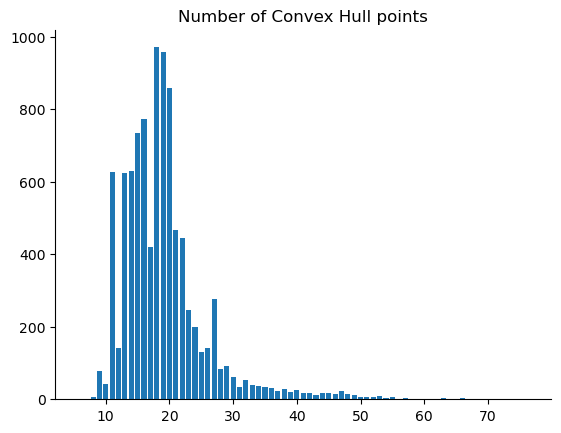

In [7]:
number_of_hulls = list(map(lambda x: len(x), hulls))
length_counter = Counter(number_of_hulls)
print(max(length_counter))
fig, axis = plt.subplots()
axis.bar(length_counter.keys(), length_counter.values()) # type: ignore
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.set_title("Number of Convex Hull points")

In [8]:
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR, LinearSVR
from sklearn.pipeline import make_pipeline  
from utils import fit_and_score, HardCodedEstimator, PadHull, ScaleToImage, FlattenCoordinates

n_points_per_hull = 100
image_width = 1920
image_height = 1080
random_state = 42

scaled_pipeline = make_pipeline(PadHull(False, n_points_per_hull),
                               ScaleToImage(image_width, image_height),
                               FlattenCoordinates(n_points_per_hull),
                               StandardScaler()) # ridge needs standard scaler

non_scaled_pipeline = make_pipeline(PadHull(False, n_points_per_hull),
                            ScaleToImage(image_width, image_height),
                            FlattenCoordinates(n_points_per_hull),
                            )


# commented out models don't work
regressors = [
    (Ridge(random_state=random_state, ), scaled_pipeline),
    #(RegressorChain(SVR()), scaled_pipeline),
    #(MultiOutputRegressor(SVR()), scaled_pipeline),
    #(RegressorChain(GradientBoostingRegressor(n_estimators=60, random_state=random_state)), non_scaled_pipeline),
    (MultiOutputRegressor(GradientBoostingRegressor(n_estimators=60, random_state=random_state)), non_scaled_pipeline),
    #(RegressorChain(LinearSVR()), scaled_pipeline),
    # MultiOutputRegressor(LinearSVR()),0
    #(DecisionTreeRegressor(max_depth=18, random_state=random_state), non_scaled_pipeline),
    (HardCodedEstimator("homography_matrix.json", 4), None),
]
evaluation = fit_and_score(regressors, hulls, gcps, random_state=random_state)
pp.pprint(evaluation)
_=joblib.dump(evaluation, "regressors.joblib")

100%|██████████| 3/3 [00:25<00:00,  8.36s/it]

[   {   'classifier': MultiOutputRegressor(estimator=GradientBoostingRegressor(n_estimators=60,
                                                         random_state=42)),
        'pipeline': Pipeline(steps=[('padhull', PadHull(n_points=100, shuffle=False)),
                ('scaletoimage', ScaleToImage(height=1080, width=1920)),
                ('flattencoordinates', FlattenCoordinates(n_coordinates=100))]),
        'test_mse': 791.6576656515059,
        'train_mse': 532.4797715327079},
    {   'classifier': Ridge(random_state=42),
        'pipeline': Pipeline(steps=[('padhull', PadHull(n_points=100, shuffle=False)),
                ('scaletoimage', ScaleToImage(height=1080, width=1920)),
                ('flattencoordinates', FlattenCoordinates(n_coordinates=100)),
                ('standardscaler', StandardScaler())]),
        'test_mse': 1035.710750128374,
        'train_mse': 796.8898577855575},
    {   'classifier': HardCodedEstimator(homography_path='homography_matrix.json', sca

## Validation on new validation camera angle

In [9]:
val_hulls = [instance[0] for instance in iter(validation_set)]
val_gcps = np.array([instance[1] for instance in iter(validation_set)])
val_gcps_tv = np.array([validation_set.get_instance(i).gcp_tv for i in range(len(validation_set))])
assert len(val_hulls) == len(val_gcps)
print(len(val_hulls))

615


In [133]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# mean absollute error is better because the dataset has faulty outliers (bicyclist)
metric = mean_absolute_error

loss_values = {}

for (regressor, pipeline) in regressors:
    if pipeline is None:
        predictions = regressor.predict(val_hulls)
        error = metric(val_gcps, predictions)
        #print(f"{regressor} mse: {error}")
    else:
        processed_hulls = pipeline.transform(val_hulls)
        predictions = regressor.predict(processed_hulls)
        error = metric(val_gcps, predictions)
        print(f"{regressor} mse: {error}")
        if isinstance(regressor, Ridge):
            loss_values["Ridge Regressor"] = error
        elif isinstance(regressor, MultiOutputRegressor):
            loss_values["Gradient Boosting Regressor"] = error

hard_coded_estimator = HardCodedEstimator("./ipm_evaluation/conf/homography_matrix.json", 4)
hard_coded_estimator.fit(val_hulls, val_gcps)
hard_coded_estimator.set_homography(validation_set.homography)
predictions = hard_coded_estimator.predict(val_hulls)
error = metric(val_gcps, predictions)
loss_values["Baseline"] = error
print(f"{hard_coded_estimator} mse: {error}")

Ridge(random_state=42) mse: 17.238121824319894
MultiOutputRegressor(estimator=GradientBoostingRegressor(n_estimators=60,
                                                         random_state=42)) mse: 13.545828183594939
HardCodedEstimator(homography_path='./ipm_evaluation/conf/homography_matrix.json',
                   scaling_factor=4) mse: 35.70769628738256


Text(0.5, 1.0, 'Mean Absolute Error in the perspective view\n(Lower is better)')

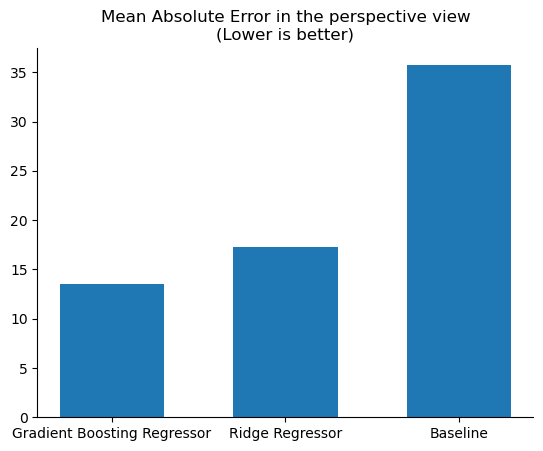

In [134]:
fig, axis = plt.subplots()
# sort loss values by value
loss_values = dict(sorted(loss_values.items(), key=lambda item: item[1]))
axis.bar(loss_values.keys(), loss_values.values(), width=0.6) # type: ignore
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.set_title("Mean Absolute Error in the perspective view\n(Lower is better)")
# make the space between bars slightly larger


In [132]:
loss_values_tv = {}

for (regressor, pipeline) in regressors:
    if pipeline is None:
        # hard coded with wrong homography matrix
        pass
    else:
        processed_hulls = pipeline.transform(val_hulls)
        predictions = regressor.predict(processed_hulls)
        projected_predictions = validation_set.project_points_from_pv(predictions)
        error = metric(val_gcps_tv, projected_predictions)
        if isinstance(regressor, Ridge):
            loss_values_tv["Ridge Regressor"] = error
        elif isinstance(regressor, MultiOutputRegressor):
            loss_values_tv["Gradient Boosting Regressor"] = error
        print(f"{regressor} mse: {error}")

hard_coded_estimator = HardCodedEstimator("./ipm_evaluation/conf/homography_matrix.json", 4)
hard_coded_estimator.fit(val_hulls, val_gcps)
hard_coded_estimator.set_homography(validation_set.homography)
predictions = hard_coded_estimator.predict(val_hulls)

projected_predictions = validation_set.project_points_from_pv(predictions)
error = metric(val_gcps_tv, projected_predictions)
loss_values_tv["Baseline"] = error
print(f"{hard_coded_estimator} mse: {error}")

Ridge(random_state=42) mse: 16.9008653706331
MultiOutputRegressor(estimator=GradientBoostingRegressor(n_estimators=60,
                                                         random_state=42)) mse: 10.745373177608785
HardCodedEstimator(homography_path='./ipm_evaluation/conf/homography_matrix.json',
                   scaling_factor=4) mse: 42.083268089485394


## Plot Perspective and Top view loss values in the same plot

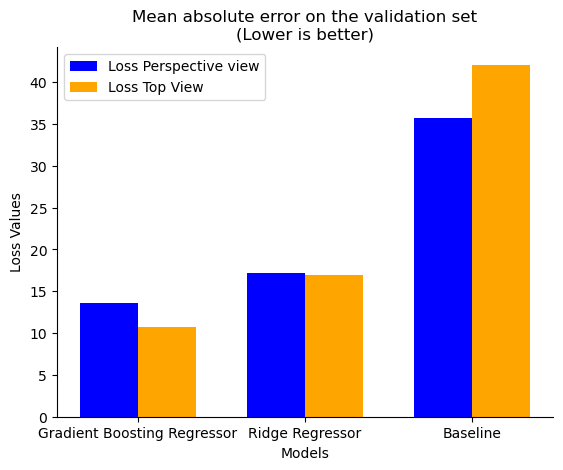

In [143]:
# Set the width for each pair of bars
bar_width = 0.35  # Adjust this value based on your preference

# Calculate the x positions for each group of bars
x_positions1 = range(len(loss_values))
x_positions2 = [x + bar_width for x in x_positions1]

# Create a bar chart
plt.bar(x_positions1, loss_values.values(), width=bar_width, label='Loss Perspective view', color='blue')
plt.bar(x_positions2, loss_values_tv.values(), width=bar_width, label='Loss Top View', color='orange')

# Set x-ticks and labels
plt.xticks([pos + bar_width / 2 for pos in x_positions1], loss_values.keys())

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Loss Values')
plt.title('Mean absolute error on the validation set\n(Lower is better)')
# remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add legend
plt.legend()

# Show the plot
plt.show()